### SYSNET Chains Tutorial

This tutorial is meant to follow the `demo_decalsdr7.ipynb` tutorial.

Chains are used in sysnet to reduce fluctuations caused by using different random numbers to initiate the neural network training. Instead of training a single neural network, sysnet can generate a number of "chains", each a separate neural network instance. The output of all the chains are then averaged together.

#### Outline For Using Chains
1. Edit the config.yaml file and set nchains to the number of chains to be produced
2. Run the sysnet pipeline, which will train each chain.
2. Create a TrainedModel object from each chain.
3. Forward the data through each TrainedModel, producing one set of outputs for each chain.
4. Average the outputs from each chain for each pixel. 


columns in `input`: [('label', '>f8'), ('hpix', '>i8'), ('features', '>f8', (18,)), ('fracgood', '>f8')]


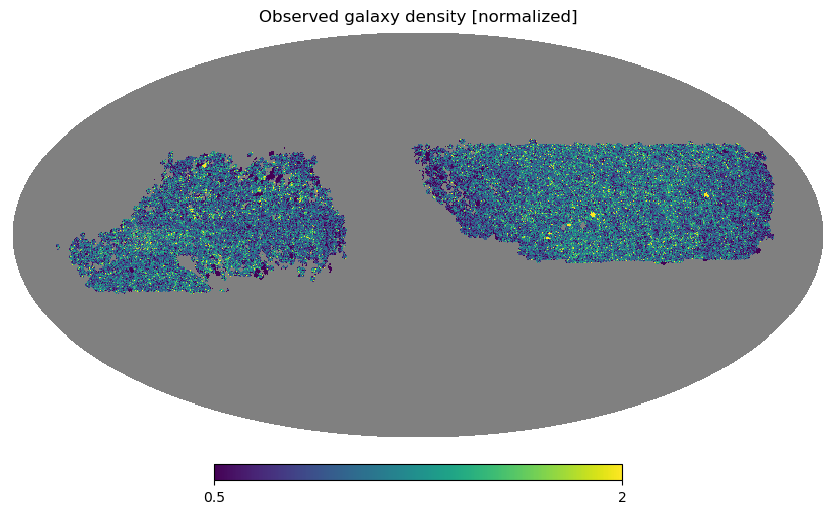

In [1]:
# importing general Python modules
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
import fitsio as ft
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# importing SYSNET modules
# add the absolute path to 'sysnetdev'
home = os.getenv('HOME')
#sys.path.append(f'{home}/Github/sysnetdev')
sys.path.append(f'{home}/Documents/Github/sysnetdev')


from sysnet import SYSNet, Config, TrainedModel
%matplotlib inline

input_path = '../input/eBOSS.ELG.NGC.DR7.table.fits'

# tabulated catalog that contains, imaging properties (features), galaxy counts (label), 
# HEALPix index (hpix), and pixel completeness (fracgood)
#input_ = ft.read('../input/eBOSS.ELG.NGC.DR7.table.fits')  # read tab. data
input_ = ft.read(input_path) 
print(f'columns in `input`: {input_.dtype}')
num_features = len(input_["features"][0])
     
# repackage hpix and label to a HEALPix map for visualization purpose    
nside = 256
ng = np.zeros(12*nside*nside)
ng[:] = np.nan
ng[input_['hpix']] = input_['label']    

# Mollweide projection
hp.mollview(ng, rot=-85, min=0.5, max=2.0,
            title='Observed galaxy density [normalized]')

#### 1. Edit the config file

Sysnet takes its input variables from a config file: `config.yaml`
The chains variable has the keyword "nchains", and is set to 1 by default.

In [ ]:
# Look at the config file
config = Config('../scripts/config.yaml')
config.__dict__

{'input_path': '../input/eBOSS.ELG.NGC.DR7.table.fits',
 'output_path': '../output/model_test',
 'restore_model': None,
 'batch_size': 512,
 'nepochs': 2,
 'nchains': 1,
 'find_lr': False,
 'find_structure': False,
 'find_l1': False,
 'do_kfold': False,
 'do_tar': False,
 'snapshot_ensemble': False,
 'normalization': 'z-score',
 'model': 'dnnp',
 'optim': 'adamw',
 'scheduler': 'cosann',
 'axes': [0, 1, 2],
 'do_rfe': False,
 'eta_min': 1e-05,
 'learning_rate': 0.001,
 'nn_structure': [4, 20],
 'l1_alpha': -1.0,
 'loss': 'pnll',
 'no_eval': False}

In [ ]:
# Set the config file parameters
# These are the parameters used by the demo NN in the demo_decalsdr7.ipynb notebook

config.update('nepochs', 70) # 70 epochs of training per chain
config.update('nchains', 20) # 20 chains
config.update('axes', [i for i in range(num_features)]) # Using all data features in our axes
config.update('batch_size', 4096) # Batch size
config.update('input_path', input_path) # Path to the input eboss data
config.update('output_path', '../output/chains_demo') # Path to the directory where the chains will be saved
config.update('learning_rate', 0.01) # Learning rate

config.__dict__

{'input_path': '../input/eBOSS.ELG.NGC.DR7.table.fits',
 'output_path': '../output/chains_demo',
 'restore_model': None,
 'batch_size': 4096,
 'nepochs': 70,
 'nchains': 20,
 'find_lr': False,
 'find_structure': False,
 'find_l1': False,
 'do_kfold': False,
 'do_tar': False,
 'snapshot_ensemble': False,
 'normalization': 'z-score',
 'model': 'dnnp',
 'optim': 'adamw',
 'scheduler': 'cosann',
 'axes': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
 'do_rfe': False,
 'eta_min': 1e-05,
 'learning_rate': 0.01,
 'nn_structure': [4, 20],
 'l1_alpha': -1.0,
 'loss': 'pnll',
 'no_eval': False}

#### 2. Run the Sysnet Pipeline

In [ ]:
# This will take some time, since it has to train each chain for 70 epochs
pipeline = SYSNet(config)
pipeline.run()

#### 3. Create the TrainedModel Objects

Each chain is saved to its own directory in the output folder. The name of the directory gives the k-fold number and the random seed for the chain. For example, the folder `model_0_208633717` was the zeroeth k-fold and had the random seed 208633717. Since this example does not do k-fold validation, all of the outputs are considered the "zeroeth" k-fold.

In [2]:
name_model = 'dnnp'

# This gets the name of each model to use in the path variable
chain_model_folders = []
for (dirpath, dirnames, filenames) in os.walk('../output/chains_demo'):
    chain_model_folders = dirnames
    break

# All of the models will share the same structure and number of features
kws = dict(nnstruct=(4, 20), num_features=num_features)

chain_tms = [] # List of models

# Create each trained model
for model_name in chain_model_folders:
    chain_tms.append(TrainedModel(name_model, '../output/chains_demo/' + model_name + '/best.pth.tar', **kws))


#### 4. Forward the Models

In [3]:
nn_labels = [] # The list of labels from each model

# All the models and the data use the same hpix, so create this variable for
# everything to use.
hpix = []

for tm in chain_tms:
    hpix, npred = tm.forward(input_path, axes=[i for i in range(num_features)])
    nn_labels.append(npred)


#### 5. Average the Outputs

In [4]:
# Transpose and average the list to get the output of all 20 chains
nn_labels = np.array(nn_labels)
nn_labelsT = nn_labels.T

nn_labels_averaged = [np.average(pixel) for pixel in nn_labelsT]

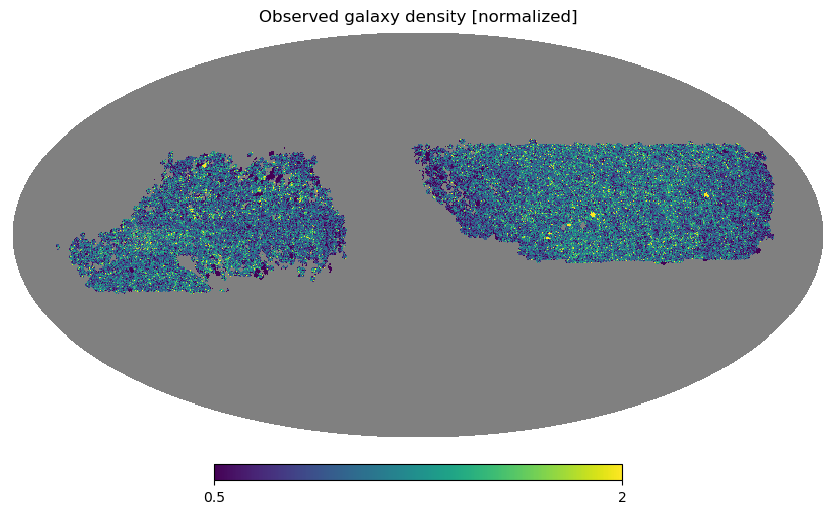

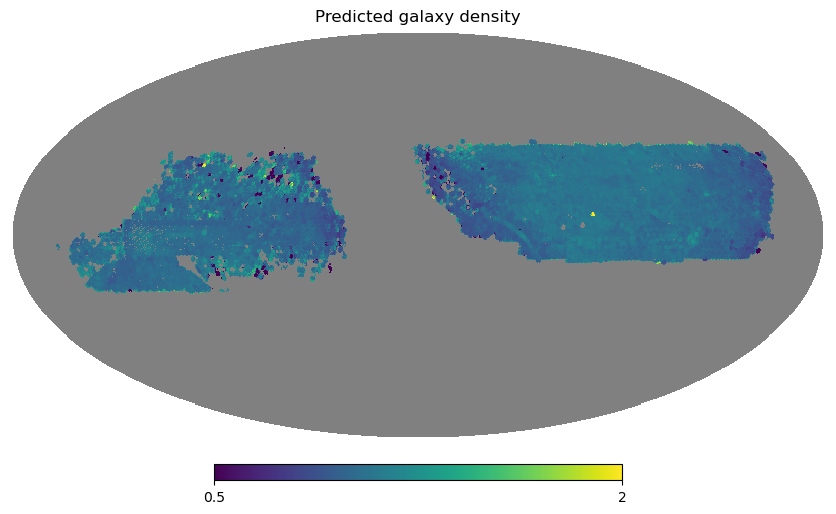

In [5]:
# We can compare visually the output of all chains combined
# Note that the model output is much smoother.
nside = 256

# Raw Data
ng = np.zeros(12*nside*nside)
ng[:] = np.nan
ng[input_['hpix']] = input_['label']

# Averaged Chains
ng_ = np.zeros(12*nside*nside)
ng_[:] = np.nan
ng_[hpix] = nn_labels_averaged

# Raw Mollweide projection
hp.mollview(ng, rot=-85, min=0.5, max=2,
            title='Observed galaxy density [normalized]')

# NN Mollweide projection
hp.mollview(ng_, rot=-85, min=0.5, max=2,
            title='Predicted galaxy density')

In [9]:
def plot_feature(features, ngal, nran, num_bins, ax, **kwargs):
    """Plots the mean number densities as a function of a systematic.
    Uses equal area binning, so each bin has the same amount of pixels in it."""

    num_pixels = len(features)

    # Sort the features to find where to put the bin edges to get an equal number of 
    # pixels per bin.
    sorted_features = np.sort(features)
    bin_edges = np.array([sorted_features[i*num_pixels//num_bins] for i in range(num_bins)])
    bin_edges = np.append(bin_edges, sorted_features[-1])

    # Weighting by the nran, ngal counts the number of galaxies in each bin
    rands, bins = np.histogram(features, bins=bin_edges, weights=nran)
    data, bins = np.histogram(features, bins, weights=ngal)

    # The normalization factor
    norm_factor = sum(rands)/sum(data)

    # Applyign the normalization factor
    normed_vals = (data/rands) * norm_factor

    # The x value of the plot is for the center of the bin
    bin_centers = (bins[1:]+bins[:-1])/2.0

    # Make the plots
    ax.plot(bin_centers, normed_vals, **kwargs)
    ax.errorbar(bin_centers, normed_vals, 0.01, **kwargs)
    return

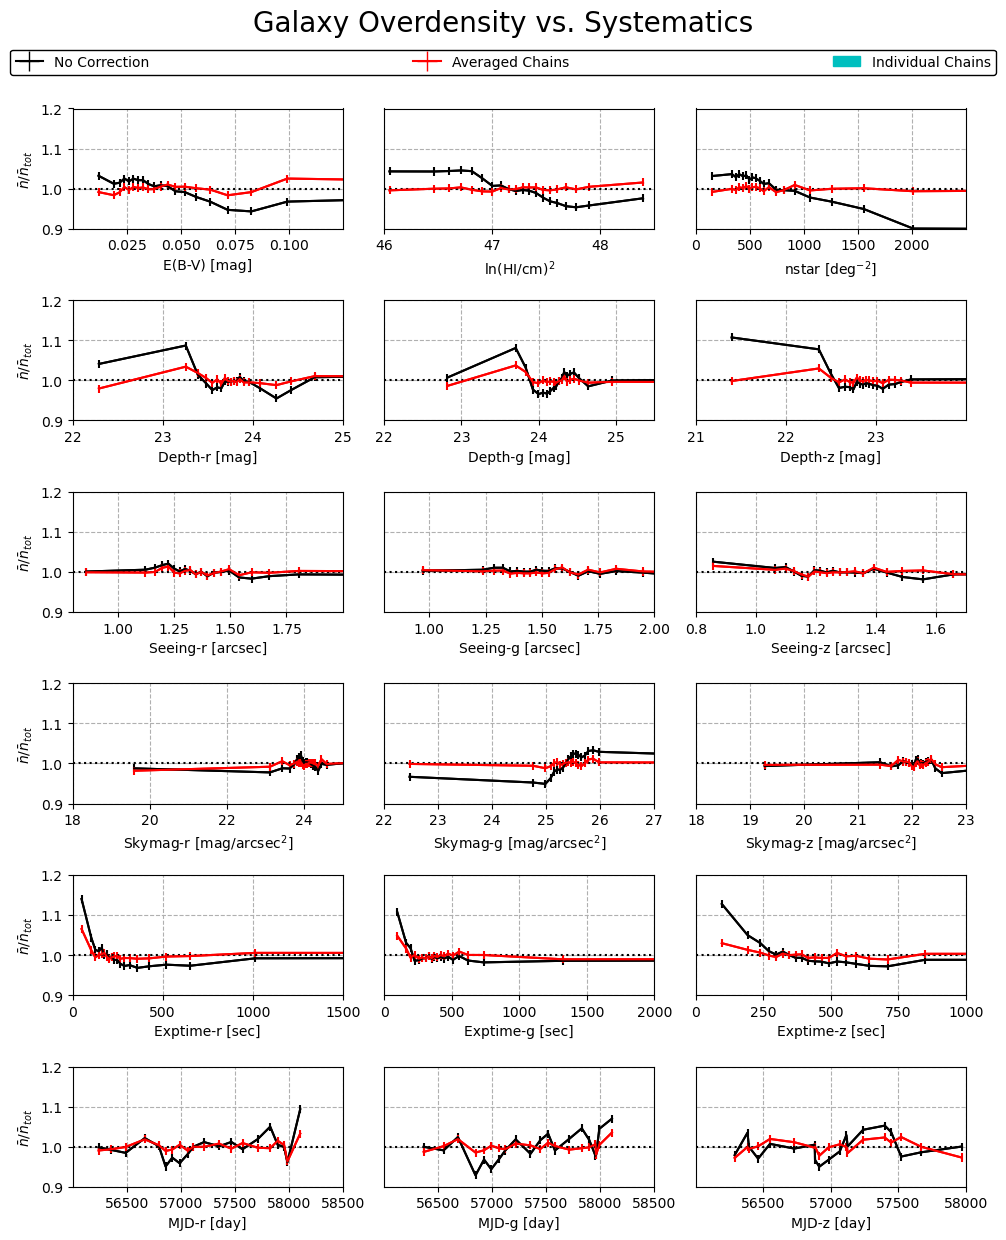

In [17]:
# Transpose the features list so that the for loops
# can iterate through the features
features = np.array(input_["features"]).T

# Number of bins in the histogram
num_bins = 20

# These are all plotting variables
legend_handles = []

left_x_lim = [[0, 46, 0],
              [22, 22, 21],
              [0.8, 0.8, 0.8],
              [18, 22, 18],
              [0, 0, 0],
              [56000, 56000, 56000],
              ]

right_x_lim = [[0.125, 48.5, 2500],
              [25, 25.5, 24],
              [2, 2, 1.7],
              [25, 27, 23],
              [1500, 2000, 1000],
              [58500, 58500, 58000],
              ]

x_labels = [["E(B-V) [mag]", r"ln(HI/cm)$^2$", r"nstar [deg$^{-2}$]"],
              ["Depth-r [mag]", "Depth-g [mag]", "Depth-z [mag]"],
              ["Seeing-r [arcsec]", "Seeing-g [arcsec]", "Seeing-z [arcsec]"],
              [r"Skymag-r [mag/arcsec$^2$]", r"Skymag-g [mag/arcsec$^2$]", r"Skymag-z [mag/arcsec$^2$]"],
              ["Exptime-r [sec]", "Exptime-g [sec]", "Exptime-z [sec]"],
              ["MJD-r [day]", "MJD-g [day]", "MJD-z [day]"],
              ]

axvline_vals = [[[0.025, 0.050, 0.075, 0.100], [46.0, 47.0, 48.0], [0, 500, 1000, 1500, 2000]],
              [[22, 23, 24, 25], [22, 23, 24, 25], [21, 22, 23]],
              [[1.0, 1.25, 1.5,  1.75], [1.0, 1.25, 1.5, 1.75, 2.0], [0.8, 1.0, 1.2, 1.4, 1.6]],
              [[18, 20, 22, 24], [22, 23, 24, 25, 26, 27], [18, 19, 20, 21, 22, 23]],
              [[0, 500, 1000, 1500], [0, 500, 1000, 1500, 2000], [0, 250, 500, 750, 1000]],
              [[56500, 57000, 57500, 58000, 58500], [56500, 57000, 57500, 58000, 58500], [56500, 57000, 57500, 58000]],
              ]


# Create the Figure object
fig, axs = plt.subplots(6, 3, sharey='row', figsize=(10, 12))

# Loop through each graph and plot the appropriate features and labels
for i in range(6):
    for j in range(3):

        feature_num = j + i*3

        # Plot all of the individual chains
        for k in range(len(nn_labels)):
            pass
            #plot_feature(features[feature_num], nn_labels[k], input_["fracgood"], 20, axs[i, j], c='c')

        # Plot the raw data and the averaged model output
        plot_feature(features[feature_num], input_["label"], input_["fracgood"], 20, axs[i, j], c="k")
        plot_feature(features[feature_num], input_["label"]/nn_labels_averaged, input_["fracgood"], 20, axs[i, j], c="r")

        # Set plotting variables
        axs[i, j].grid(linestyle="--")
        axs[i, j].set_xlim(left_x_lim[i][j], right_x_lim[i][j])
        axs[i, j].set_ylim(0.9, 1.2)
        axs[i, j].axhline(y=1, c="k", linestyle=":")
        axs[i, j].set_xlabel(x_labels[i][j])
        axs[i, j].set_xticks(axvline_vals[i][j])

        if j == 0:
            axs[i, j].set_ylabel(r"$\bar n / \bar n_{tot}$")
        else:
            axs[i, j].tick_params(left=False)

# Create the legend
raw_data_label = mlines.Line2D([], [], color='k', marker='+',
                          markersize=15, label='No Correction')

nn_ave_label = mlines.Line2D([], [], color='r', marker='+',
                          markersize=15, label='Averaged Chains')

nn_ind_label = mpatches.Patch(color='c', label='Individual Chains')

legend_handles.append(raw_data_label)
legend_handles.append(nn_ave_label)
legend_handles.append(nn_ind_label)

fig.legend(handles=legend_handles, bbox_to_anchor=(0., 0.9, 1., .102), loc='upper center', 
           ncols=3, fancybox="False", mode='expand', framealpha=1, edgecolor="black")

fig.suptitle("Galaxy Overdensity vs. Systematics", fontsize="20", y = 1.03)
fig.tight_layout()
plt.show()